In [1]:
import itertools
import os

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize

from vibrojet.basis_utils import ContrBasis, HermiteBasis
from vibrojet.keo import Gmat, com, pseudo
from vibrojet.potentials import h2co_AYTY
from vibrojet.taylor import deriv_list

plt.rcParams.update(
    {"text.usetex": True, "font.family": "serif", "font.serif": ["Computer Modern"]}
)

jax.config.update("jax_enable_x64", True)

Equilibrium coordinates, around which the Taylor series expansions will be build

In [2]:
vmin = optimize.minimize(
    h2co_AYTY.poten, [1, 1, 1, 120 * np.pi / 180, 120 * np.pi / 180, np.pi]
)
r0 = vmin.x
v0 = vmin.fun
print("Equilibrium coordinates:", r0)
print("Min of the potential:", v0)

# r0 = np.array([1.20337419, 1.10377465, 1.10377465, 2.1265833, 2.1265833, np.pi])

Equilibrium coordinates: [1.20337419 1.10377465 1.10377465 2.1265833  2.1265833  3.14159265]
Min of the potential: 3.0346763583235566e-11


Define internal to Cartesian coordinate transformation

In [3]:
masses = [12.0, 15.99491463, 1.00782505, 1.00782505]  # masses of C, O, H, H

ncoo = len(r0)


# @eckart(r0, masses)
@com(masses)
def internal_to_cartesian(internal_coords):
    rCO, rCH1, rCH2, aOCH1, aOCH2, tau = internal_coords
    xyz = [
        [0.0, 0.0, 0.0],
        [0.0, 0.0, rCO],
        [
            rCH1 * jnp.sin(aOCH1) * jnp.cos(tau * 0.5),
            -rCH1 * jnp.sin(aOCH1) * jnp.sin(tau * 0.5),
            rCH1 * jnp.cos(aOCH1),
        ],
        [
            rCH2 * jnp.sin(aOCH2) * jnp.cos(tau * 0.5),
            rCH2 * jnp.sin(aOCH2) * jnp.sin(tau * 0.5),
            rCH2 * jnp.cos(aOCH2),
        ],
    ]
    return jnp.array(xyz, dtype=jnp.float64)

Generate $N$-mode expansions for the KEO and PES

In [4]:
# expansion of G-matrix

gmat_max_nmode = 6  # max N-mode expansion order
gmat_max_order = 8  # max total expansion order

gmat_terms = np.array(
    [
        elem
        for elem in itertools.product(
            *[range(0, gmat_max_order + 1) for _ in range(len(r0))]
        )
        if np.count_nonzero(elem) <= gmat_max_nmode and sum(elem) <= gmat_max_order
    ]
)
print("Max N-mode expansion order for G-matrix:", gmat_max_nmode)
print("Max expansion order for G-matrix:", gmat_max_order)
print("Number of expansion terms in G-matrix:", len(gmat_terms))

gmat_file = f"_h2co_gmat_coefs_n_{gmat_max_nmode}.npy"
if os.path.exists(gmat_file):
    print(
        f"load G-matrix expansion coefs from file {gmat_file} (delete file to recompute coefs)"
    )
    gmat_coefs = np.load(gmat_file)
else:
    gmat_coefs = deriv_list(
        lambda x: Gmat(x, masses, internal_to_cartesian), gmat_terms, r0, if_taylor=True
    )
    np.save(gmat_file, gmat_coefs)

Max N-mode expansion order for G-matrix: 6
Max expansion order for G-matrix: 8
Number of expansion terms in G-matrix: 3003
Time for d= 0 : 0.68 s
Time for d= 1 : 0.02 s
Time for d= 2 : 1.31 s
Time for d= 3 : 2.14 s
Time for d= 4 : 3.55 s
Time for d= 5 : 5.46 s
Time for d= 6 : 7.83 s
Time for d= 7 : 10.58 s
Time for d= 8 : 14.59 s


In [5]:
# expansion of pseudopotential

pseudo_max_nmode = 6  # max N-mode expansion order
pseudo_max_order = 8  # max total expansion order

pseudo_terms = np.array(
    [
        elem
        for elem in itertools.product(
            *[range(0, pseudo_max_order + 1) for _ in range(len(r0))]
        )
        if np.count_nonzero(elem) <= pseudo_max_nmode and sum(elem) <= pseudo_max_order
    ]
)
print("Max N-mode expansion order for pseudopotential:", pseudo_max_nmode)
print("Max expansion order for pseudopotential:", pseudo_max_order)
print("Number of expansion terms in pseudopotential:", len(pseudo_terms))

pseudo_file = f"_h2co_pseudo_coefs_n_{pseudo_max_nmode}.npy"

if os.path.exists(pseudo_file):
    print(
        f"load pseudopotential expansion coefs from file {pseudo_file} (delete file to recompute coefs)"
    )
    pseudo_coefs = np.load(pseudo_file)
else:
    pseudo_coefs = deriv_list(
        lambda x: pseudo(x, masses, internal_to_cartesian),
        pseudo_terms,
        r0,
        if_taylor=True,
    )
    np.save(pseudo_file, pseudo_coefs)

Max N-mode expansion order for pseudopotential: 6
Max expansion order for pseudopotential: 8
Number of expansion terms in pseudopotential: 3003
Time for d= 0 : 10.9 s
Time for d= 1 : 0.0 s
Time for d= 2 : 21.92 s
Time for d= 3 : 40.0 s
Time for d= 4 : 65.36 s
Time for d= 5 : 102.5 s
Time for d= 6 : 159.76 s
Time for d= 7 : 807.04 s
Time for d= 8 : 335.15 s


In [6]:
# expansion of potential

poten_max_nmode = 6  # max N-mode expansion order
poten_max_order = 8  # max total expansion order

poten_terms = np.array(
    [
        elem
        for elem in itertools.product(
            *[range(0, poten_max_order + 1) for _ in range(len(r0))]
        )
        if np.count_nonzero(elem) <= poten_max_nmode and sum(elem) <= poten_max_order
    ]
)
print("Max N-mode expansion order for potential:", poten_max_nmode)
print("Max expansion order for potential:", poten_max_order)
print("Number of expansion terms in potential:", len(poten_terms))

poten_file = f"_h2co_poten_coefs_n_{poten_max_nmode}.npy"
if os.path.exists(poten_file):
    print(
        f"load potential expansion coefs from file {poten_file} (delete file to recompute coefs)"
    )
    poten_coefs = np.load(poten_file)
else:
    poten_coefs = deriv_list(h2co_AYTY.poten, poten_terms, r0, if_taylor=True)
    np.save(poten_file, poten_coefs)

Max N-mode expansion order for potential: 6
Max expansion order for potential: 8
Number of expansion terms in potential: 3003
load potential expansion coefs from file _h2co_poten_coefs_n_6.npy (delete file to recompute coefs)


Define linear mapping between coordinates of Hermite functions and internal coordinates

In [7]:
mask = gmat_terms != 0
ind0 = np.where(mask.sum(axis=1) == 0)[0][0]
mu = np.diag(gmat_coefs[ind0])[:ncoo]

mask = poten_terms != 0
ind2 = np.array(
    [
        np.where((mask.sum(axis=1) == 1) & (poten_terms[:, icoo] == 2))[0][0]
        for icoo in range(ncoo)
    ]
)
freq = poten_coefs[ind2] * 2

lin_a = np.sqrt(np.sqrt(mu / freq))
lin_b = r0

print("x->r linear mapping parameters 'a':", lin_a)
print("x->r linear mapping parameters 'b':", lin_b)

# x->r linear mapping function
x_to_r_map = lambda x, icoo: lin_a[icoo] * x + lin_b[icoo]

x->r linear mapping parameters 'a': [0.05234934 0.11034365 0.11034365 0.15407403 0.15407403 0.2994783 ]
x->r linear mapping parameters 'b': [1.20337419 1.10377465 1.10377465 2.1265833  2.1265833  3.14159265]


Define primitive Hermite basis

In [8]:
ncoo = len(r0)
nbas = [40] * ncoo
npoints = [60] * ncoo

p_r1, p_r2, p_r3, p_alpha1, p_alpha2, p_tau = [
    HermiteBasis(
        icoo,
        nbas[icoo],
        npoints[icoo],
        lambda x: x_to_r_map(x, icoo),
        lambda r: r - r0[icoo],
        lambda r: r - r0[icoo],
        gmat_terms[:, icoo],
        poten_terms[:, icoo],
        pseudo_terms[:, icoo],
    )
    for icoo in range(ncoo)
]

In [9]:
emax = [20000, 40000, 40000, 40000, 40000, 20000]
c_r1, c_r2, c_r3, c_alpha1, c_alpha2, c_tau = [
    ContrBasis(
        (icoo,),
        [p_r1, p_r2, p_r3, p_alpha1, p_alpha2, p_tau],
        lambda _: True,
        gmat_terms,
        gmat_coefs,
        poten_terms,
        poten_coefs,
        pseudo_terms,
        pseudo_coefs,
        emax=emax[icoo],
    )
    for icoo in range(ncoo)
]

e = c_r1.enr
print("Solutions for r1 mode:\n", f"zpe = {e[0]}\n", e - e[0])
e = c_r2.enr
print("\nSolutions for r2 mode:\n", f"zpe = {e[0]}\n", e - e[0])
e = c_r3.enr
print("\nSolutions for r3 mode:\n", f"zpe = {e[0]}\n", e - e[0])
e = c_alpha1.enr
print("Solutions for alpha1 mode:\n", f"zpe = {e[0]}\n", e - e[0])
e = c_alpha2.enr
print("Solutions for alpha2 mode:\n", f"zpe = {e[0]}\n", e - e[0])
e = c_tau.enr
print("Solutions for tau mode:\n", f"zpe = {e[0]}\n", e - e[0])

Solutions for r1 mode:
 zpe = 3480.182163301948
 [    0.          1765.58780997  3507.96403054  5227.07885766
  6922.87647578  8595.29878547 10244.29115647 11869.81089577
 13471.83930227 15050.39838113 16605.57353713 18137.54479697
 19646.64384843]

Solutions for r2 mode:
 zpe = 3729.8638994020243
 [    0.          2832.39154393  5535.50842986  8111.36262409
 10581.15617158 12998.37623103 15436.80238063 17955.89017115
 20585.68115396 23336.2789106  26208.96423812 29201.71076627
 32311.37241954 35534.53135123 38867.83071708]

Solutions for r3 mode:
 zpe = 3729.8638995306283
 [    0.          2832.39154403  5535.50843006  8111.36262438
 10581.15617191 12998.37623135 15436.80238086 17955.89017126
 20585.68115391 23336.27891039 26208.96423773 29201.71076571
 32311.3724188  35534.5313503  38867.83071596]
Solutions for alpha1 mode:
 zpe = 3420.5722031923174
 [    0.          1497.94115685  2995.54446088  4492.71269508
  5989.34546065  7485.33896674  8980.58579641 10474.97464585
 11968.390033

In [10]:
c_r2_r3 = ContrBasis(
    (1, 2),
    [c_r1, c_r2, c_r3, c_alpha1, c_alpha2, c_tau],
    lambda _: True,
    gmat_terms,
    gmat_coefs,
    poten_terms,
    poten_coefs,
    pseudo_terms,
    pseudo_coefs,
    emax=20000,
)

e = c_r2_r3.enr
print(len(e))
print("Solutions for r2+r3 modes:\n", f"zpe = {e[0]}\n", e - e[0])

36
Solutions for r2+r3 modes:
 zpe = 4423.688235220489
 [    0.          2820.91319301  2865.12079931  5543.18083703
  5558.74437541  5702.75482823  8137.4195871   8140.6024215
  8374.69294031  8453.08734627 10619.01049626 10619.58038694
 10972.02097967 11008.71139199 11159.9011369  13043.39985156
 13043.52169372 13470.06780455 13481.32353113 13688.42563222
 13790.67321326 15484.16036745 15484.1987282  15902.72312672
 15906.03709185 16171.64216802 16233.29042508 16374.66157239
 18000.55477162 18000.57672135 18346.77331839 18348.20814242
 18614.39319382 18646.89480605 18791.43670482 18902.59435789]


In [11]:
c_alpha1_alpha2 = ContrBasis(
    (3, 4),
    [c_r1, c_r2, c_r3, c_alpha1, c_alpha2, c_tau],
    lambda _: True,
    gmat_terms,
    gmat_coefs,
    poten_terms,
    poten_coefs,
    pseudo_terms,
    pseudo_coefs,
    emax=20000,
)

e = c_alpha1_alpha2.enr
print(len(e))
print("Solutions for alpha1+alpha2 modes:\n", f"zpe = {e[0]}\n", e - e[0])

114
Solutions for alpha1+alpha2 modes:
 zpe = 3654.841863450913
 [    0.          1259.54471223  1575.4313389   2522.37910971
  2831.07784122  3151.52673033  3789.19889663  4090.32052231
  4403.06442827  4727.76403623  5060.66927829  5353.88764549
  5658.488673    5975.00496626  6303.599504    6337.42192821
  6622.47209673  6918.5601031   7226.40617991  7546.3801749
  7620.05286824  7878.46294078  7896.72762613  8183.99868989
  8482.76017883  8793.57746825  8909.1211901   9116.64660511
  9177.26636882  9451.75201917  9455.47934204  9744.81303678
 10046.01497367 10205.14851848 10359.48472215 10464.65753799
 10685.23145907 10733.62921079 11013.2594322  11022.8254495
 11304.46359773 11508.61910187 11607.83098685 11759.42713268
 11923.58312086 12019.0265243  12251.52638374 12288.73985676
 12569.63605658 12590.99465916 12819.98041265 12862.47968356
 13062.05847841 13167.68965955 13312.20070857 13485.2951334
 13571.8397319  13814.87991148 13842.18407157 14124.15958964
 14139.64418733 14155.5

In [12]:
e_max = 10000

e1 = np.copy(c_r1.enr - c_r1.enr[0])
e23 = np.copy(c_r2_r3.enr - c_r2_r3.enr[0])
e45 = np.copy(c_alpha1_alpha2.enr - c_alpha1_alpha2.enr[0])
e6 = np.copy(c_tau.enr - c_tau.enr[0])


def select_quanta(ind):
    i1, i23, i45, i6 = ind
    cond = e1[i1] + e23[i23] + e45[i45] + e6[i6] <= e_max
    return cond


sol = ContrBasis(
    (0, 1, 2, 3),
    [c_r1, c_r2_r3, c_alpha1_alpha2, c_tau],
    select_quanta,
    gmat_terms,
    gmat_coefs,
    poten_terms,
    poten_coefs,
    pseudo_terms,
    pseudo_coefs,
    emax=20000,
    store_me=False,
)

e = sol.enr
print(len(e))
print("Solutions:\n", f"zpe = {e[0]}\n", e - e[0])

541
Solutions:
 zpe = 5772.72525661284
 [    0.          1167.58930329  1249.42808838  1500.83097051
  1747.1509004   2328.68715203  2424.17264696  2496.49818522
  2669.76672254  2722.51600203  2785.43565359  2846.38788803
  2909.49541866  3003.67423452  3004.84228843  3245.85796019
  3480.77597068  3484.55323275  3589.26373834  3679.42606125
  3742.09471444  3832.59004579  3894.34573304  3944.58001407
  3946.39880318  4001.48699018  4028.80491004  4065.00976902
  4090.2708941   4171.68250452  4178.75885337  4208.27633844
  4257.17216459  4267.32605176  4349.2666098   4411.32621883
  4482.31150987  4519.15851486  4542.93928141  4583.7873018
  4636.82728617  4636.8834504   4750.21466325  4750.5872887
  4756.1708417   4852.03799301  4939.93845561  4984.26567055
  4993.92191746  5008.30754634  5062.29468783  5105.19932776
  5128.43303807  5158.32887711  5174.71896522  5200.40519393
  5201.09960816  5253.66368758  5270.17201813  5273.37642304
  5346.96370312  5364.63982522  5372.3526407   

In [8]:
nmode_list = list(
    set(
        [
            (n, 6, 6) if i == 0 else (6, n, 6) if i == 1 else (6, 6, n)
            for i in range(3)
            for n in range(1, 7)
        ]
    )
)

nmode_enr = {}

for nmode_gmat, nmode_poten, nmode_pseudo in nmode_list:
    print(
        f"\nRun for N-mode G-matrix/potential/pseudopotential = {nmode_gmat}/{nmode_poten}/{nmode_pseudo} ..."
    )
    ind = np.where(np.count_nonzero(gmat_terms, axis=1) <= nmode_gmat)[0]
    gmat_terms_nmode = gmat_terms[ind]
    gmat_coefs_nmode = gmat_coefs[ind]

    ind = np.where(np.count_nonzero(poten_terms, axis=1) <= nmode_poten)[0]
    poten_terms_nmode = poten_terms[ind]
    poten_coefs_nmode = poten_coefs[ind]

    ind = np.where(np.count_nonzero(pseudo_terms, axis=1) <= nmode_pseudo)[0]
    pseudo_terms_nmode = pseudo_terms[ind]
    pseudo_coefs_nmode = pseudo_coefs[ind]

    ncoo = len(r0)
    nbas = [40] * ncoo
    npoints = [60] * ncoo

    p_r1, p_r2, p_r3, p_alpha1, p_alpha2, p_tau = [
        HermiteBasis(
            icoo,
            nbas[icoo],
            npoints[icoo],
            lambda x: x_to_r_map(x, icoo),
            lambda r: r - r0[icoo],
            lambda r: r - r0[icoo],
            gmat_terms_nmode[:, icoo],
            poten_terms_nmode[:, icoo],
            pseudo_terms_nmode[:, icoo],
        )
        for icoo in range(ncoo)
    ]

    emax = [20000, 40000, 40000, 40000, 40000, 20000]

    c_r1, c_r2, c_r3, c_alpha1, c_alpha2, c_tau = [
        ContrBasis(
            (icoo,),
            [p_r1, p_r2, p_r3, p_alpha1, p_alpha2, p_tau],
            lambda _: True,
            gmat_terms_nmode,
            gmat_coefs_nmode,
            poten_terms_nmode,
            poten_coefs_nmode,
            pseudo_terms_nmode,
            pseudo_coefs_nmode,
            emax=emax[icoo],
        )
        for icoo in range(ncoo)
    ]

    c_r2_r3 = ContrBasis(
        (1, 2),
        [c_r1, c_r2, c_r3, c_alpha1, c_alpha2, c_tau],
        lambda _: True,
        gmat_terms_nmode,
        gmat_coefs_nmode,
        poten_terms_nmode,
        poten_coefs_nmode,
        pseudo_terms_nmode,
        pseudo_coefs_nmode,
        emax=20000,
    )

    c_alpha1_alpha2 = ContrBasis(
        (3, 4),
        [c_r1, c_r2, c_r3, c_alpha1, c_alpha2, c_tau],
        lambda _: True,
        gmat_terms_nmode,
        gmat_coefs_nmode,
        poten_terms_nmode,
        poten_coefs_nmode,
        pseudo_terms_nmode,
        pseudo_coefs_nmode,
        emax=20000,
    )

    e_max = 12000
    e1 = np.copy(c_r1.enr - c_r1.enr[0])
    e23 = np.copy(c_r2_r3.enr - c_r2_r3.enr[0])
    e45 = np.copy(c_alpha1_alpha2.enr - c_alpha1_alpha2.enr[0])
    e6 = np.copy(c_tau.enr - c_tau.enr[0])

    def select_quanta(ind):
        i1, i23, i45, i6 = ind
        cond = e1[i1] + e23[i23] + e45[i45] + e6[i6] <= e_max
        return cond

    sol = ContrBasis(
        (0, 1, 2, 3),
        [c_r1, c_r2_r3, c_alpha1_alpha2, c_tau],
        select_quanta,
        gmat_terms_nmode,
        gmat_coefs_nmode,
        poten_terms_nmode,
        poten_coefs_nmode,
        pseudo_terms_nmode,
        pseudo_coefs_nmode,
        emax=20000,
        store_me=False,
    )

    e = sol.enr - sol.enr[0]
    print(e[:10])
    nmode_enr[(nmode_gmat, nmode_poten, nmode_pseudo)] = e[:101]


Run for N-mode G-matrix/potential/pseudopotential = 4/6/6 ...
[   0.         1166.98217963 1249.55460698 1500.12418175 1746.15067642
 2326.8576776  2422.75584365 2495.35161023 2666.80034114 2719.82198412]

Run for N-mode G-matrix/potential/pseudopotential = 6/6/6 ...
[   0.         1166.98218206 1249.55460035 1500.1241549  1746.1507101
 2326.8576807  2422.75584117 2495.35160381 2666.80031835 2719.82193749]

Run for N-mode G-matrix/potential/pseudopotential = 6/1/6 ...
[   0.         1188.74976711 1274.03409085 1534.09276004 1793.78938463
 2383.5972494  2463.48444044 2540.43232268 2725.29172186 2777.05253619]

Run for N-mode G-matrix/potential/pseudopotential = 6/3/6 ...
[   0.         1167.02434832 1249.79358986 1499.99888341 1746.15036016
 2326.95309915 2423.17405122 2495.70101546 2666.61916364 2719.86012782]

Run for N-mode G-matrix/potential/pseudopotential = 6/4/6 ...
[   0.         1166.98226322 1249.55483273 1500.12405772 1746.15069143
 2326.85785227 2422.75686909 2495.35195618 

In [23]:
np.savez("_h2co_nmode_enr.npz", **{str(key): val for key, val in nmode_enr.items()})

Define linear mapping between coordinates of Hermite functions and internal coordinates

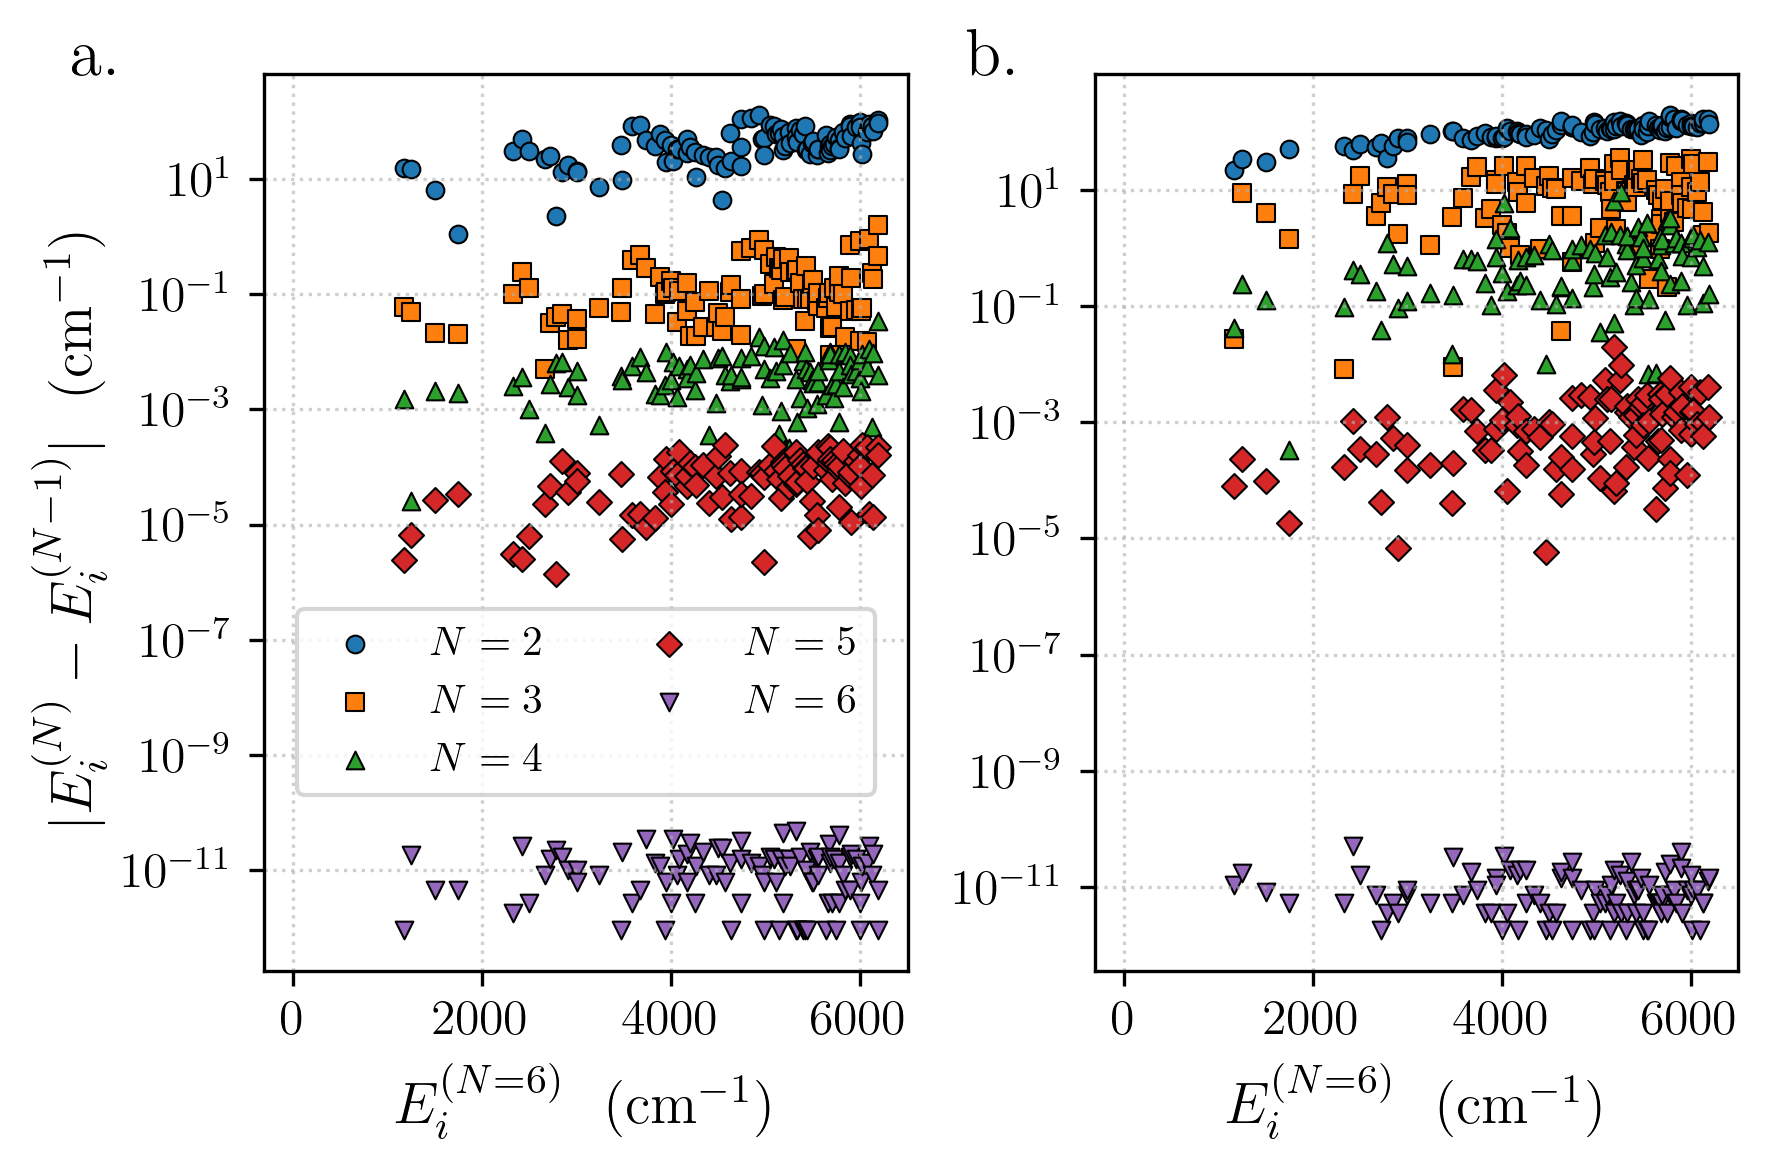

In [121]:
import matplotlib.pyplot as plt

data = np.load("_h2co_nmode_enr.npz")
enr = {eval(key): data[key] for key in data.files}

de_gmat = np.array([np.abs(enr[(n, 6, 6)] - enr[(n - 1, 6, 6)]) for n in range(2, 7)])
de_poten = np.array([np.abs(enr[(6, n, 6)] - enr[(6, n - 1, 6)]) for n in range(2, 7)])
# label = [n for n in range(2, 7)]

fig, axes = plt.subplots(1, 2, figsize=(6, 4), dpi=300)
for i, (ax, de) in enumerate(zip(axes, (de_gmat, de_poten))):
    for n, (d, marker) in enumerate(zip(de, ("o", "s", "^", "D", "v"))):
        ax.scatter(
            enr[(6, 6, 6)],
            d,
            marker=marker,
            s=18,
            edgecolors="black",
            linewidths=0.5,
            label=f"$N={n+2}$",
        )

    ax.set_yscale("log")
    ax.set_xlabel("$E_i^{(N=6)}$~~(${\\rm cm}^{-1}$)", fontsize=14)
    if i == 0:
        ax.set_ylabel("$|E_i^{(N)}-E_i^{(N-1)}|$~~(${\\rm cm}^{-1})$", fontsize=14)
        ax.legend(
            fontsize=10,
            ncol=2,
            loc="center",
            bbox_to_anchor=(0.5, 0.3),
        )
    ax.grid(True, linestyle=":", alpha=0.6)
    ax.tick_params(axis="both", labelsize=12)

# Add panel labels
axes[0].text(
    -0.3,
    1.05,
    "a.",
    transform=axes[0].transAxes,
    fontsize=16,
    fontweight="bold",
    va="top",
    ha="left",
)

axes[1].text(
    -0.2,
    1.05,
    "b.",
    transform=axes[1].transAxes,
    fontsize=16,
    fontweight="bold",
    va="top",
    ha="left",
)
plt.tight_layout()
fig.savefig(f"_h2co_nmode_enr.pdf", format="pdf", bbox_inches="tight")